<a href="https://colab.research.google.com/github/saptarshidatta96/DigitRecognizerCNN/blob/master/VGG16_based_SVC_One_vs_Rest_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import numpy as np
import cv2
from PIL import Image
import tensorflow as tf
import pandas as pd
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
import itertools
import os
import os.path
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import os 
import xml.etree.ElementTree as ET
from collections import OrderedDict
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [78]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [79]:
!pwd

/content


In [ ]:
!tar -xvf "/content/gdrive/MyDrive/VOCtrainval_11-May-2012.tar" -C "/content/"  

In [81]:
def parseXML(tree):
  roww = OrderedDict()
  for elements in tree.iter():
    if elements.tag == 'filename':
      roww['{}'.format(elements.tag)] = str(elements.text)
    if elements.tag =='object':
      for element in elements:
        if element.tag == 'name':
          roww['{}'.format(element.tag)] = str(element.text)
  return roww



In [82]:
df_annot = []
for file in os.listdir('/content/VOCdevkit/VOC2012/Annotations'):
  if file.startswith('.') == 0:
    tree = ET.parse(os.path.join('/content/VOCdevkit/VOC2012/Annotations', file))
    roww = parseXML(tree)
    df_annot.append(roww)

df_annotation = pd.DataFrame(df_annot)

In [83]:
df_annotation.head()

,filename,name
0,2012_001950.jpg,person
1,2012_003193.jpg,person
2,2008_001188.jpg,person
3,2011_005301.jpg,person
4,2010_001543.jpg,person


In [84]:
list_of_unique_class =df_annotation['name'].unique()
list_of_files = df_annotation['filename'].unique()
annotations_list = df_annotation.values.tolist()

In [85]:
len(annotations_list)

17125

In [86]:
df_train_sample = df_annotation.sample(frac = 0.04)
train_sample = df_train_sample.values.tolist()
validation_sample = df_annotation.sample(frac = 0.02).values.tolist()

In [87]:
list_of_unique_class

array(['person', 'bus', 'motorbike', 'diningtable', 'chair', 'cat',
       'bird', 'car', 'sofa', 'bicycle', 'boat', 'aeroplane',
       'pottedplant', 'train', 'cow', 'dog', 'horse', 'bottle', 'sheep',
       'tvmonitor'], dtype=object)

In [88]:
img_dir = '/content/VOCdevkit/VOC2012/JPEGImages'

In [89]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [90]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

for layer in model.layers:
  layer.trainable = False

extractor = keras.Model(inputs=model.inputs, outputs=[layer.output for layer in model.layers][20])

In [91]:
def output_nn(sample):
  output = []
  class_name = []
  for entry in train_sample:
    image = Image.open('/content/VOCdevkit/VOC2012/JPEGImages/{}'.format(entry[0]))
    image = cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    features = extractor(tf.expand_dims(image_tensor, axis=0)).numpy()
    features = np.squeeze(features, axis=0)
    output.append(features)
    class_name.append(entry[1])

  return output, class_name

In [92]:
svc_model = OneVsRestClassifier(SVC())

In [93]:
def train_svc(sample):
  train_output, train_class_name = train_nn(sample)
  svc_model.fit(train_output, train_class_name)

In [94]:
train_svc(train_sample)

In [95]:
def test_svc(sample):
  test_output, test_class_name = output_nn(sample)
  prediction = svc_model.predict(test_output)

  return test_class_name, prediction

In [96]:
test_class_name, prediction = test_svc(validation_sample)

In [97]:
accuracy_score(test_class_name, prediction)

0.9722627737226277

In [98]:
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

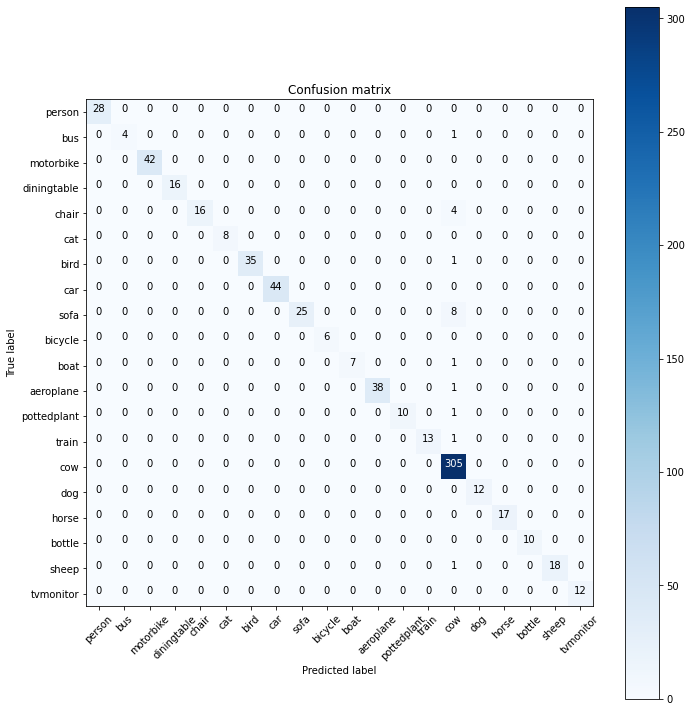

In [99]:
cm = confusion_matrix(test_class_name, prediction)
classes = ('person', 'bus', 'motorbike', 'diningtable', 'chair', 'cat',
       'bird', 'car', 'sofa', 'bicycle', 'boat', 'aeroplane',
       'pottedplant', 'train', 'cow', 'dog', 'horse', 'bottle', 'sheep',
       'tvmonitor')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes)